In [1]:
import pandas as pd
import cv2
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, sys, codecs, glob
from PIL import Image, ImageDraw

import numpy as np
import pandas as pd
import cv2

import torch
torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.enabled = False

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [15]:
class XunFeiDataset(Dataset):
    def __init__(self, img_path, transform):
        self.img_path = img_path
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img

    def __len__(self):
        return len(self.img_path)

In [96]:
train_df = pd.read_csv('./电商图像检索_数据集/train.csv')

In [105]:
%pylab inline
def show_image(paths):
    plt.figure(figsize=(10, 8))
    for idx, path in enumerate(paths):
        plt.subplot(1, len(paths), idx+1)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])    

Populating the interactive namespace from numpy and matplotlib


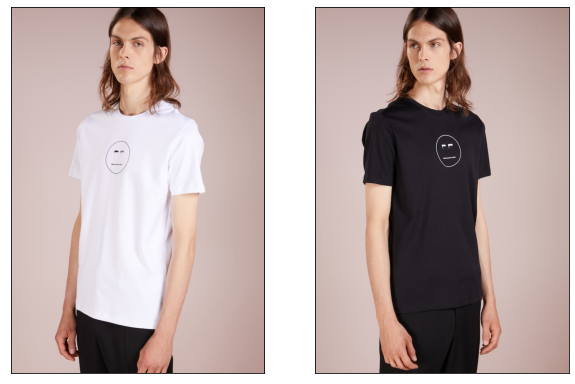

In [106]:
show_image(
    ['./电商图像检索_数据集/train/'+x 
     for x in train_df['label'].iloc[0].split()]
)

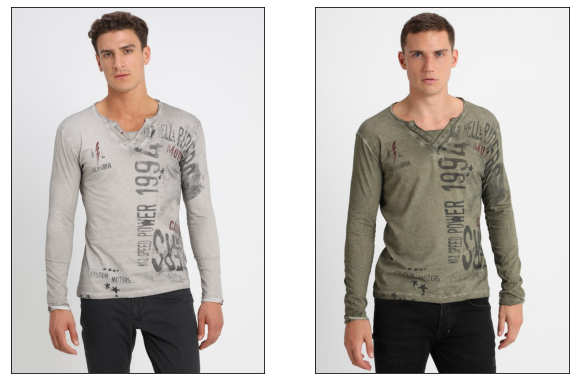

In [113]:
show_image(
    ['./电商图像检索_数据集/train/'+x 
     for x in train_df['label'].iloc[200].split()]
)

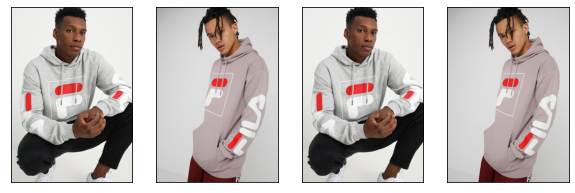

In [110]:
show_image(
    ['./电商图像检索_数据集/train/'+x 
     for x in train_df['label'].iloc[150].split()]
)

In [80]:
test_path = glob.glob('./电商图像检索_数据集/test/*')
test_path.sort()
test_path = np.array(test_path)

In [20]:
test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_path,
                        transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ),
    batch_size=50, shuffle=False, num_workers=5,
)

In [ ]:
import timm
model = timm.create_model('resnet18', pretrained=True, in_chans=3)
model.fc = torch.nn.Identity()
model.cuda()

In [34]:
test_feats = []
with torch.no_grad():
    for data in test_loader:
        data = data.cuda()
        feat = model(data)
        test_feats.append(feat.data.cpu().numpy())

In [27]:
import numpy as np
from sklearn.preprocessing import normalize

In [36]:
test_feats = np.vstack(test_feats)
test_feats = normalize(test_feats)

In [91]:
test_submit = []
for feat in test_feats:
    dis = np.dot(feat, test_feats.T)
    ids = dis.argsort()[::-1]
    
    test_submit.append([
        test_path[ids[0]].split('/')[-1],
        
        [x.split('/')[-1] for x in test_path[ids[dis[ids] > 0.85]]]
    ])

In [92]:
test_submit = pd.DataFrame(test_submit, columns=['name', 'label'])

In [93]:
test_submit['label'] = test_submit['label'].apply(lambda x: ' '.join(x))

In [94]:
test_submit.to_csv('submit.csv',index=None)

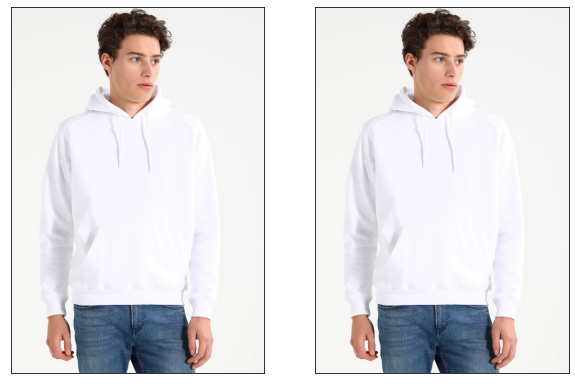

In [111]:
show_image(
    ['./电商图像检索_数据集/test/'+x 
     for x in test_submit['label'].iloc[150].split()]
)

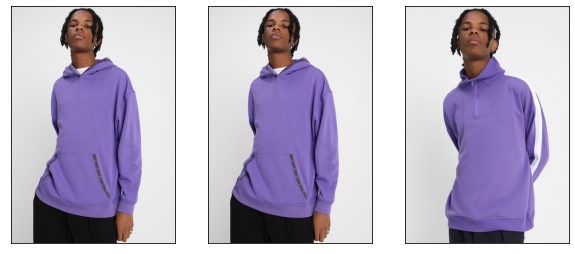

In [112]:
show_image(
    ['./电商图像检索_数据集/test/'+x 
     for x in test_submit['label'].iloc[100].split()]
)